# Деревья решений

## Теория

Дерево принятия решений - алгоритм машинного обучения для решения задач классификации и регресии, эффективный для **обнаружения нелинейных зависимостей**.

Методы, основанные на деревьях решений, используют стратификацию или сегментирование пространства признаков на области. Набор правил, который может использоваться при этом можно легко представить в виде дерева. Это делает методы, основанные на деревьях решений, простыми в интерпретации.

**Дерево решений** – это иерархическая схема принятия решений в виде графа:
* В узлах лежат некоторые правила. Обычно для непрерывных значений их представляют как $[x_j \leq t_j]$: **значение признака $x_j$ сравнивается с некоторым пороговым значением $t_j$**. С **категориальными признакакми** у деревьев решений особые отношения (об этом ниже).
* Каждая ветка соответствует выходному значению условия, вся ветка целиком – альтернативное решение.
* Каждому узлу соответствует область в пространстве признаков.
* Области для листьев не содержат внутри других областей. Прогноз в листе может быть вещественным числом для задачи регрессии, а также классом или вероятностями классов для задачи классификации. Пример:
$$(\text{ Значение признака } x_1 \text{ меньше } t_1\text{ ) AND ( Значение признака } x_2 \text{ меньше } t_2 \text{ )  AND ... ==> Класс 1 }$$


## sklearn.tree

[Пример взят отсюда](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
# Load data
iris = load_iris()
pd.DataFrame(iris.data, columns = ['feat_A', 'feat_B', 'feat_C', 'feat_D']).head()

,feat_A,feat_B,feat_C,feat_D
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

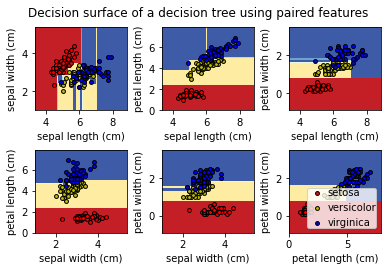

In [4]:
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    clf = DecisionTreeClassifier().fit(X, y)

    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight");

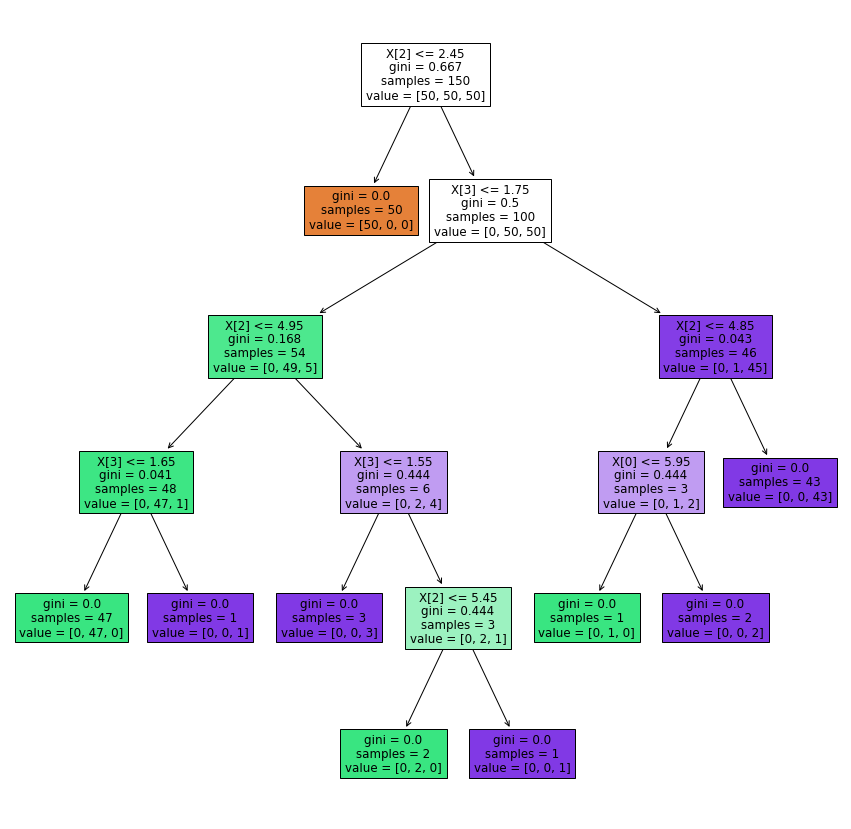

In [5]:
plt.figure(figsize=(15, 15))
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.show()

## Построение деревьев решений

### Жадный алгорим построения деревьев решений

Как построить дерево с хорошей разделяющей способностью? Можем перебирать признаки и построить сколь угодно много деревьев, дающих на обучающей выборке точность 100%, **если в ней нет примеров с одинаковыми x, но разными y**. Однако, это приведет нас к переобучению. Худшим случаем является ситуация, когда в листах остается по одному объекту обучающей выборки. Задача же нахождения наиболее простого решающего дерева является NP-полной, то есть (если $P \neq NP$) экспоненциально сложной.

Поэтому на практике используется постоение деревьев решений по принципу **жадного алгоритма**: от корня к листьям.
* Выбирается корень, разбивающий выборку на 2
* Каждый из потомков корня также разбивается на 2
* И так далее

Применение дерева решений для нового объекта – проверка атрибутов – путь по ветви до листа к одному из классов / значений / ...

Как выбрать корень? Как разбить потомок на 2 подвыборки? Об этом ниже. Пока рассмотрим идею алгоритма жадного поиска.

Пусть дано:
* $X$ - некоторое множество объектов
* $x^j$ - некоторый непрерывный признак
* $t$ - заданный порог
* Будем сравнивать значение признака с порогом: $[x^j \leqslant t]$
* $Q(X, j, t)$ - критерий ошибки на множестве при заданном пороге (определим его немного ниже)

Параметры $j, t$ в условии $[x^j \leqslant t]$ выбираются так, чтобы минимизировать критерий ошибки: $Q(X, j, t) \rightarrow \min\limits_{j,t}$.

Эти параметры можно подобрать перебором: можно показать, что значений параметра $t$ столько, сколько различных значений признака $x^j$ на обучающей выборке.

Пусть были выбраны значения параметров, тогда множество $X$ разбивается на два подмножества, соответствующих своим дочерним вершинам:

$$X_l = {x \in X | [x^j \leqslant t]}, \quad X_r = {x \in X | [x^j > t]}$$

Такую же процедуру повторяют для каждой из дочерних вершин до наступления **критерия остановки**, тогда очередная вершина с подвыборкой $X_m$ объявляется листком, и процесс разбиения останавливается. В этом случае возникает необходимость определить прогноз, который будет содержаться в данном листе. В разных задачах применяются разные подходы:
* **В задаче регресии** оптимально давать средний ответ по этой выборке, если функционал - среднеквадратичная ошибка:
$$a_m = \frac{1}{|X_m|} \sum\limits_{i \in X_m} y_i$$
* **В задаче классификации** можно использовать 2 стратегии:
    * Класс, наиболее часто встречающийся в $X_m$: $$a_m = argmax_{y \in Y} \sum\limits_{i \in X_m} [y_i = y]$$
    * Доля объектов разных классов в $X_m$ (псевдо-вероятности классов): $$a_{mk} = \frac{1}{|X_m|} \sum\limits_{i \in X_m} [y_i = k]$$

### Критерий информативности

Общая схема построения дерева следующая: на каждом шаге выбирается тот признак, при разделении выборки по которому **прирост информации (в соответствии с критерием разбиения) оказывается наибольшим**. Дальше процедура повторяется рекурсивно, **пока критерий не станет равен нулю**. Но если доводить до такого, то дерево точно переобучится. Чтобы избежать переобучения, используются разные эвристики для "ранней остановки" или "отсечения". Так когда стоит остановиться?

Критерий ошибки для решающих деревьев зависит от обоих листов:

$$Q(X, j, t) = \frac{|H_l|}{|X|}H(X_l) + \frac{|H_r|}{|X|}H(X_r)$$

Здесь $H(X)$ - критерий информативности (его значение мало, тогда, когда разброс ответов в $X$ небольшой). Определим критерии информативности для задач классификации и регресии.

**Критерии информативности для задачи классификации**:

* **Неопределенность Джини (Gini impurity)**
    * Неопределенность Джини: $H(X) = \sum\limits_{k=1}^n p_k(1-p_k) = 1 - \sum\limits_{k=1}^n {p_k}^2$
    * $p_k$ — доля объектов класса $k$, попавших в выборку $X$: $p_k = \frac{1}{X} \sum\limits_{i \in X}[y_i = k]$
    * Неопределенность Джини измеряет "равномерность", ее можно интерпретировать как вероятность ошибки случайного классификатора (вероятность класса $k$ равна $p_k$)
    * Неопределенность Джини $\geq$ 0
    * Неопределенность Джини максимальна, когда все объекты в $X$ принадлежат одному классу


* **Энтропия Шеннона**
    * Энтропия Шеннона: $H(X) = - \sum\limits_{k=1}^n p_k \ln(p_k)$
    * Энтропия Шеннона определяется для системы с $n$ возможными состояниями
    * Энтропийный критерий $\geq$ 0
    * Энтропийный критерий максимален, когда все объекты в $X$ принадлежат одному классу
    * Энтропия соответствует степени хаоса в системе: чем выше энтропия, тем менее упорядочена система и наоборот
    * Энтропийный критерий показывает, насколько распределение классов в $X$ отличается от вырожденного.


* **Критерий информативности для задачи регрессии**
    * $H(X) = \frac{1}{|X|} \sum\limits_{i \in X} (y_i - \overline y(X))^2$
    * $\overline y = \frac{1}{|X|} \sum\limits_{i \in X} y_i$
    * В случае регрессии разброс ответов - это дисперсия

### Критерий останова

Переобученное решающее дерево не будет обобщать информацию для новых объектов, которых не было в обучающей выборке. Для предотвращения переобучения используют различные **критерии останова** и **методы «стрижки» деревьев**.

**Критерий останова** - ограничение, используемое, чтобы принять решение: разбивать вершину или сделать ее листовой. Примеры:
* Ограничение максимальной глубины дерева
* Ограничение минимального числа объектов в листе
* Ограничение максимального количества листьев в дереве
* Останов в случае, если все объекты в листе относятся к одному классу
* Требование, что функционал качества при дроблении улучшался не менее, чем на заданное количество процентов

### Стрижка деревьев (pruning)

**Стрижка деревьев** - выявление и удаление ветвей, обладающих слабой предсказательной способностью, наличие которых приводит к перепрогнозу алгоритма. Идея метода заключается в том, что сначала строится переобученное дерево, а затем производится оптимизация его структуры с целью улучшения обобщающей способности. Стрижка - это эффективная, но очень ресурсоемкая процедура.

Есть несколько вариантов того, как производится обрезка: снизу вверх или сверху вниз. Одним из методов стрижки является cost-complexity pruning.

## Алгоритмы построения дерева

**ID3 (Iterative Dichotomizer 3)** 
* Задача классификации
* Энтропийный критерий 
* Не может работать с пропусками в данных
* Число потомков в узле дерева не ограничено

Алгоритм работы:
1. Пройтись циклом по всем признакам и посчитать энтропии
2. Выбрать признак, для которого энтропия минимальна
3. Сделать разбиение по признаку
4. Продолжать процедуру для дочерних узлов до тех пор, пока в каждом листе не окажутся объекты одного класса

**C4.5** — усовершенствованная версия алгоритма ID3
* Энтропийный критерий
* Может работать с пропусками в данных

Обработка пропущенных значений осуществляется с помощью метода, который игнорирует объекты с пропущенными значениями при вычислении критерия ветвления, а затем разделяет такие объекты по поддеревьям в соответствии с вероятностью классов в ветках.

## Работа с категориальными признаками

### Подход 1: N-арные деревья

N-арное дерево - это дерево, из каждой вершины которого может выходить до $n$ ребер. В случае использования этого подхода для непрерывных признаков строятся уже привычные конструкции с двумя разбиениями, а для категориальных признаков - с $n$. И в качестве разбиения выбирается тот признак, у которого будет наименьшее значение критерия информативности.

Пусть некоторый категориальный признак $x^j$ принимает $n$ значений: ${c_1, ..., c_n}$. Будем делать разбиение по этому признаку не на два, а на $n$ листов. Тогда в i-ый лист попадут объекты, для которых выполняется: $x^j = c_i$. Критерий ошибки в таком случае выглядит следующим образом: $Q(X, j) = \sum\limits_{i = 1}^n \frac{|X_i|}{|X|} H(X) \rightarrow \min\limits_{j}$

Использование N-арных деревьев может привести к переобучению в случае использования их на маленьких выборках. 

### Подход 2: Бинарные деревья с разбиением множества значений

В случае использования этого подхода, мы также строим бинарные деревья.

Пусть некоторый категориальный признак $x^j$ принимает $n$ значений: ${c_1, ..., c_n}$. Разобьем множество значений признака на 2 непересекающихся подмножества $C_1$ и $C_2$. Тогда мы сможем построить бинарное дерево с заданным условием: $[x^j \in C_1]$.

Как стоит делать разбиение множества значений признака на 2 подмножества? Чтобы не делать полный перебор по множеству всех возможных пар, можно закодировать категории признаков натуральными числами и после этого работать с ними по привычной схеме.

## Простая реализация решающего дерева

In [6]:
import warnings

import numpy as np
import pandas as pd

from random import shuffle
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits, load_boston, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

warnings.filterwarnings('ignore')

In [7]:
RANDOM_STATE = 17

In [8]:
def get_clf_proba(y):
    _, counts = np.unique(y, return_counts=True)
    return counts / np.sum(counts, axis=0, keepdims=True)

def entropy(y):
    """
    Entropy
    For example, for 2 classes:
        F(X) = -1 * (p_0 * log2(p_0) + p_1 * log2(p_1))
    """
    clf_proba = get_clf_proba(y)
    return -1.0 * np.sum(clf_proba * np.log2(clf_proba))

def gini(y):
    """
    Gini impurity
    For example, for 2 classes:
        F(X) = 1 - (p_0^2 + p_1^2)
    """
    clf_proba = get_clf_proba(y)
    return 1 - np.sum(clf_proba ** 2)

def mse(y):
    return np.average((y - np.mean(y, axis=0)) ** 2, axis=0)
    
def mae(y):
    return np.average(np.abs(y - np.mean(y, axis=0)), axis=0)

In [9]:
class Node():
    """
    A class representing a node in decision tree.
    Args:
        feature_ind Index of the feature column.
                    Default: -1
        threshhold  The threshhold for split for the current node.
                    Default: None
        labels      Labels that belong to current node.
                    Leaf node of tree contains all the labels belong to 
                    that leaf node, while non-leaf nodes have this field None.
        left        Object reference for left child node.
                    For leaf node this field is None.
        right       Object reference for right child node.
                    For leaf node this field is None.
        value       Value of the node.
                    This is used with gradient boost classifier where 
                    value is calculated based on loss function.
                    For other cases , mostly this will be None.
                    Default: None
    """ 

    def __init__(self,
                 feature_ind=-1,
                 threshold=None,
                 labels=None,
                 value=None,
                 left=None,
                 right=None):

        self.feature_ind = feature_ind
        self.threshold = threshold
        self.labels = labels
        self.value = value
        self.left = left
        self.right = right

In [10]:
class DecisionTree(BaseEstimator):
    """
    Simple implementation of Decision Tree
    for classification and regression tasks:
        * For classification the prediction is majority probability class.
        * For regression the prediction is averge of all the node labels.

    Args:
        max_depth           The maximum depth of the tree.
                            Default: np.inf
        min_samples_split   The minimum number of samples required 
                            to split an internal node.
                            Default: 2
        criterion           The function to measure the quality of a split.
                            For classification:
                                - gini
                                - entropy
                            For regression:
                                - mse
                                - mae
        max_features        The number of features to consider when 
                            looking for the best split
                            Default: 0
                            Default: gini
        random_state        Controls the randomness of the estimator.
                            Default: 42
    """
    CLASSIFICATION_CRITERIONS = ['entropy', 'gini']
    REGRESSION_CRITERIONS = ['mse', 'mae']
    KNOWN_CRITERIONS = CLASSIFICATION_CRITERIONS + REGRESSION_CRITERIONS
    CRITERIONS_MAPPING = {'entropy': entropy,
                          'gini': gini,
                          'mse': mse,
                          'mae': mae}
    
    def __init__(self,
                 max_depth=np.inf,
                 min_samples_split=2, 
                 criterion='gini',
                 max_features=0,
                 random_state=42):

        self.random_state = random_state

        self.criterion = criterion
        if self.criterion not in self.KNOWN_CRITERIONS:
            raise Exception(f"Unknown criterion type: {self.criterion}")
        
        self.max_depth = max_depth
        if self.max_depth <= 0:
            raise Exception(f"Invalid max_depth value: {self.max_depth}")

        self.min_samples_split = min_samples_split
        if self.min_samples_split <= 0:
            raise Exception(f"Invalid min_samples_split value: {self.min_samples_split}")
        
        self.max_features = max_features
        if self.max_features < 0:
            raise Exception(f"Invalid max_features value: {self.max_features}")

        self.n_features = 0
        self.n_samples = 0
        self.root = None
        self.min_impurity = 1e-7

    def _shuffle(self, features_list):
        """
        Shuffle list of features of dataframe
        """
        shuffle(features_list)
        if self.max_features == 0:
            return features_list
        return features_list[:self.max_features]

    def _calculate_criterion(self, y, y_left, y_right):
        """
        A functional to be maximized to find an optimal partition at a given node has the form
        Q = (F(X) * F(X) - |X_l| * F(X_l) - |X_r| * F(X_r)) / |X|
        """
        root_value = self.CRITERIONS_MAPPING[self.criterion](y) * len(y)
        left_value = self.CRITERIONS_MAPPING[self.criterion](y_left) * len(y_left)
        right_value = self.CRITERIONS_MAPPING[self.criterion](y_right) * len(y_right)
        return (root_value - left_value - right_value) / self.n_samples

    def _split_by_th(self, df_with_targets, threshold, feature_ind):
        """
        Split dataframe into two parts by given threshold
        """
        if isinstance(threshold, int) or isinstance(threshold, float):
            left = np.where(df_with_targets[:, feature_ind] < threshold)
            right = np.where(df_with_targets[:, feature_ind] >= threshold)
        else:
            left = np.where(df_with_targets[:, feature_ind] != threshold)
            right = np.where(df_with_targets[:, feature_ind] == threshold)
        return left, right

    def _build_tree(self, X, y, current_depth, inds, max_criterion_value=-np.inf):
        feature_ind = -1
        threshold = None
        n_samples, n_features = np.shape(X)
        shuffled_features_inds = self._shuffle(list(range(n_features)))

        if current_depth < self.max_depth and n_samples > self.min_samples_split:
            x_left, y_left = [], [], 
            x_right, y_right = [], []
            left_inds, right_inds = [], []
            
            for feat_ind in shuffled_features_inds:
                for feature_th in np.unique(X[:, feat_ind]):
                    data = np.concatenate((X, y), axis=1)
                    inv_obj_by_th, val_obj_by_th = self._split_by_th(data, feature_th, feat_ind)
                    
                    if len(inv_obj_by_th) and len(val_obj_by_th):
                        x_nth = data[inv_obj_by_th][:, :n_features]
                        y_nth = data[inv_obj_by_th][:, n_features:]

                        x_th = data[val_obj_by_th][:, :n_features]
                        y_th = data[val_obj_by_th][:, n_features:]

                        criterion_value = self._calculate_criterion(y, y_nth, y_th)

                        if criterion_value > max_criterion_value:
                            max_criterion_value = criterion_value
                            x_left, y_left = x_nth, y_nth
                            x_right, y_right = x_th, y_th
                            left_inds = inds[inv_obj_by_th]
                            right_inds = inds[val_obj_by_th]
                            threshold = feature_th
                            feature_ind = feat_ind

            if max_criterion_value > self.min_impurity:
                node = Node(feature_ind=feature_ind, threshold=threshold)
                node.left = self._build_tree(x_left, y_left, current_depth + 1, left_inds)
                node.right = self._build_tree(x_right, y_right, current_depth + 1, right_inds)
                return node

        return Node(labels=y.tolist())

    def fit(self, X, y):
        """
        Build a decision tree classifier from the training set (X, y).
        Returns an instance of the class DecisionTree.
        """
        if type(X) == pd.DataFrame:
            X = X.to_numpy()

        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        np.random.seed(self.random_state)
        self.n_samples, self.n_features = X.shape
        inds = np.array(list(range(self.n_samples)))
        self.root = self._build_tree(X, y, current_depth=0, inds=inds)
        return self

    def get_node_prediction(self, node):
        if self.criterion in self.CLASSIFICATION_CRITERIONS:
            unique, counts = np.unique(node.labels, return_counts=True)
            return unique[np.argmax(counts)]
        else:
            return np.average(node.labels)

    def get_object_prediction(self, current_object, node=None):
        if node is None:
            node = self.root
            
        if node.labels:
            if node.value:
                return node.value
            else:
                return self.get_node_prediction(node)

        next_node = node.left
        node_threshold = node.threshold

        if current_object[node.feature_ind] >= node_threshold:
            next_node = node.right

        return self.get_object_prediction(current_object, next_node)

    def predict(self, X):
        """
        Predict class or regression value for X.
            For classification:
                prediction for an instance x_i falling into leaf L 
                will be the class, mostly represented among instances in L.
            For regression:
                Mean value of targets for all instances in leaf L.
        """
        if type(X) == pd.DataFrame:
            X = X.to_numpy()

        preds = np.array([self.get_object_prediction(p) for p in X])
        return preds
        
    def predict_proba(self, X):
        """
        Predict class probabilities of the input samples X.
        (only for classification).
        """
        if self.criterion in self.CLASSIFICATION_CRITERIONS:
            if type(X) == pd.DataFrame:
                X = X.to_numpy()
            proba = np.array([self.get_object_prediction(p) for p in X])
            return proba
        else:
            raise Exception(f"Invalid operation for criterion: {self.criterion}")

In [11]:
iris = load_iris()
X = iris.data
y = iris.target

In [12]:
dt = DecisionTree()
dt.fit(X, y)

DecisionTree()

In [13]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
dt.predict(X)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [15]:
# Classification
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=17)

In [16]:
dt = DecisionTree(criterion='gini')
dt.fit(X_train, y_train)
dt.predict(X_test)

array([1., 2., 8., 1., 9., 5., 8., 9., 8., 5., 6., 3., 5., 2., 9., 8., 5.,
       3., 9., 6., 6., 3., 6., 4., 6., 2., 6., 7., 3., 1., 8., 6., 1., 1.,
       0., 6., 3., 5., 5., 9., 5., 6., 0., 5., 9., 5., 1., 8., 8., 2., 9.,
       4., 0., 9., 1., 1., 1., 1., 0., 2., 1., 2., 0., 7., 9., 8., 8., 6.,
       0., 2., 8., 3., 4., 6., 1., 1., 2., 9., 5., 7., 5., 8., 3., 5., 1.,
       8., 9., 5., 4., 7., 7., 8., 3., 0., 2., 7., 8., 9., 4., 0., 5., 6.,
       4., 0., 1., 3., 5., 1., 7., 7., 4., 2., 5., 5., 8., 5., 2., 4., 2.,
       7., 4., 1., 1., 5., 9., 5., 1., 6., 5., 5., 4., 9., 4., 2., 7., 8.,
       4., 7., 4., 9., 7., 7., 5., 9., 2., 0., 0., 3., 5., 8., 3., 9., 5.,
       3., 6., 3., 7., 1., 6., 5., 9., 7., 4., 4., 0., 9., 4., 5., 0., 9.,
       8., 5., 5., 4., 2., 1., 5., 1., 6., 9., 2., 1., 9., 7., 0., 4., 4.,
       7., 0., 1., 5., 8., 2., 9., 9., 6., 0., 3., 9., 5., 4., 9., 9., 6.,
       2., 4., 7., 3., 0., 4., 9., 2., 3., 0., 3., 5., 8., 5., 8., 9., 2.,
       7., 2., 6., 9., 0.

In [17]:
dt = DecisionTree(criterion='entropy')
dt.fit(X_train, y_train)
dt.predict(X_test)

array([1., 8., 7., 1., 9., 5., 8., 9., 8., 1., 4., 3., 5., 0., 9., 8., 5.,
       3., 9., 6., 6., 5., 6., 4., 6., 2., 6., 7., 5., 1., 8., 4., 4., 1.,
       0., 2., 3., 5., 5., 9., 5., 6., 0., 5., 3., 5., 1., 8., 2., 4., 9.,
       4., 0., 8., 8., 1., 1., 1., 0., 4., 1., 8., 0., 7., 9., 8., 8., 6.,
       0., 8., 8., 3., 4., 6., 4., 3., 2., 9., 9., 7., 5., 8., 3., 5., 1.,
       8., 9., 5., 4., 7., 7., 8., 3., 0., 2., 4., 9., 9., 4., 0., 5., 6.,
       4., 0., 1., 3., 3., 1., 8., 7., 4., 2., 5., 5., 3., 9., 8., 4., 2.,
       7., 4., 1., 8., 5., 1., 5., 8., 6., 5., 5., 4., 9., 4., 2., 7., 8.,
       4., 4., 4., 9., 7., 4., 5., 9., 2., 0., 0., 3., 5., 3., 3., 9., 5.,
       3., 6., 8., 7., 4., 6., 1., 4., 7., 4., 4., 0., 9., 4., 3., 0., 9.,
       8., 5., 5., 4., 2., 1., 5., 7., 4., 9., 2., 2., 9., 9., 0., 4., 4.,
       7., 0., 1., 5., 8., 2., 9., 9., 6., 0., 3., 9., 5., 6., 3., 9., 6.,
       2., 4., 7., 3., 0., 6., 9., 2., 8., 0., 3., 5., 8., 5., 9., 9., 2.,
       7., 0., 6., 9., 0.

In [18]:
y_test

array([1, 2, 7, 3, 9, 5, 8, 9, 8, 1, 4, 3, 5, 0, 9, 9, 5, 3, 9, 6, 6, 3,
       6, 4, 6, 2, 6, 7, 3, 1, 8, 4, 1, 1, 0, 2, 3, 5, 5, 5, 5, 6, 0, 5,
       3, 5, 1, 8, 2, 9, 9, 4, 0, 8, 8, 1, 1, 1, 0, 4, 1, 2, 0, 7, 9, 8,
       8, 6, 0, 8, 8, 3, 4, 6, 4, 3, 2, 3, 9, 7, 5, 8, 3, 5, 1, 8, 9, 5,
       4, 7, 7, 8, 3, 0, 2, 7, 9, 9, 4, 0, 5, 6, 4, 0, 1, 3, 3, 1, 8, 7,
       4, 2, 5, 5, 3, 9, 6, 4, 2, 7, 4, 1, 8, 5, 1, 5, 8, 6, 5, 5, 4, 9,
       4, 2, 7, 8, 4, 4, 4, 9, 7, 1, 9, 9, 2, 0, 0, 3, 5, 8, 1, 9, 5, 3,
       6, 8, 7, 4, 6, 1, 9, 7, 6, 4, 0, 9, 4, 3, 0, 9, 8, 5, 5, 4, 2, 1,
       5, 1, 6, 9, 2, 2, 9, 9, 0, 4, 4, 7, 0, 1, 5, 8, 2, 9, 9, 6, 0, 3,
       9, 5, 6, 3, 9, 6, 2, 4, 7, 3, 0, 6, 9, 2, 8, 0, 3, 5, 8, 5, 9, 9,
       2, 7, 0, 6, 9, 0, 5, 1, 4, 5, 3, 0, 9, 2, 5, 1, 4, 2, 8, 0, 8, 1,
       3, 3, 3, 6, 2, 1, 9, 9, 0, 4, 5, 2, 8, 3, 1, 7, 5, 1, 4, 9, 1, 2,
       2, 0, 4, 2, 0, 3, 8, 7, 3, 3, 9, 3, 7, 6, 4, 8, 3, 7, 1, 6, 4, 2,
       3, 7, 5, 6, 4, 3, 7, 6, 7, 1, 1, 7, 9, 6, 3,

In [19]:
# Regression
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.2, random_state=17)

In [20]:
dt = DecisionTree(criterion='mse')
dt.fit(X_train, y_train)
dt.predict(X_test)

array([26.2 , 22.4 , 19.5 , 47.5 , 22.4 , 20.7 , 42.  , 20.65, 10.2 ,
       24.  , 27.1 , 24.4 , 22.6 , 14.9 , 19.35, 20.7 , 19.35, 19.95,
       16.6 , 19.75, 28.4 , 21.6 , 12.7 , 14.2 , 23.9 , 31.6 , 14.9 ,
       13.1 , 14.4 , 23.4 , 25.  , 19.35, 20.65, 19.7 , 23.3 , 27.1 ,
       29.9 , 12.7 , 20.05, 43.65, 10.8 , 22.4 , 29.6 , 22.2 , 19.75,
       14.9 , 33.3 , 26.4 , 29.4 , 14.35, 23.6 , 18.55, 32.  , 21.55,
       16.2 , 13.2 , 22.05, 22.65, 48.8 , 24.  , 24.75, 18.55, 19.2 ,
       19.75, 15.6 , 22.7 , 29.6 , 23.9 , 28.7 , 22.95, 31.2 , 15.15,
       23.3 , 36.5 , 13.1 , 24.7 , 24.75, 27.5 , 50.  , 20.1 , 13.3 ,
       39.25, 19.35, 23.6 , 23.15, 21.1 , 19.75, 10.55, 19.35,  7.8 ,
       19.35, 14.9 , 20.1 , 28.  , 24.7 , 19.2 , 26.4 , 18.95, 14.3 ,
       20.1 , 22.55, 23.9 ])

In [21]:
dt = DecisionTree(criterion='mae')
dt.fit(X_train, y_train)
dt.predict(X_test)

array([29.6 , 16.5 , 19.5 , 44.8 , 24.3 , 20.6 , 43.9 , 22.4 , 10.35,
       28.5 , 16.5 , 24.  , 22.8 , 16.25, 22.  , 20.  , 21.45, 20.1 ,
       16.6 , 18.2 , 35.25, 22.1 , 18.35, 13.45, 24.75, 44.8 , 16.85,
       11.4 , 19.75, 21.45, 23.9 , 16.2 , 20.7 , 22.  , 24.9 , 17.95,
       29.3 , 12.2 , 18.2 , 50.  ,  8.55, 17.3 , 28.  , 24.7 , 20.1 ,
       11.7 , 31.6 , 23.9 , 23.75, 14.55, 29.3 , 21.3 , 29.2 , 20.5 ,
       20.2 , 15.6 , 19.4 , 22.5 , 42.9 , 28.  , 25.1 , 19.5 , 24.7 ,
       18.2 , 15.6 , 23.45, 21.6 , 31.15, 32.8 , 25.  , 29.3 , 15.7 ,
       24.9 , 31.  ,  9.5 , 24.7 , 24.75, 27.5 , 50.  , 22.05,  9.5 ,
       33.4 , 21.45, 22.5 , 20.7 , 20.85, 19.9 ,  5.3 , 24.4 , 10.35,
       20.9 , 13.5 , 19.75, 31.15, 24.7 , 22.8 , 28.  , 27.1 , 13.6 ,
       21.45, 16.2 , 23.15])

In [22]:
y_test

array([30.5, 22. , 17.7, 50. , 23.3, 19.9, 37.6, 23.3,  8.8, 32.5, 20. ,
       20.5, 22.7, 13.4, 20.9, 20.3, 23.4, 10.9, 18.9, 18.2, 28.2, 23.6,
       17.4, 16.7, 24.6, 39.8, 14.9,  9.7, 17.8, 23.9, 28.1, 17.1, 22.2,
       21.7, 24.1, 14.4, 30.1,  8.3, 20.4, 38.7,  8.7, 20.1, 36.2, 22.9,
       19.2, 13.5, 33.2, 22. , 21. , 12.6, 23.9, 16.1, 28.4, 25. , 18.5,
       15.6, 22.5, 23.2, 43.1, 23.9, 23. , 23.2, 18.9, 23. , 13.4, 24.2,
       24.4, 29.8, 31.6, 20.6, 37. , 19.6, 24.5, 36. , 11.8, 24.1, 25.3,
       30.1, 50. , 23.1, 13.4, 37.9, 19.7, 23.7, 25. , 20.6, 20.4, 13.8,
       20.7,  7.4, 21.7, 13. , 17.5, 27.9, 21.9, 19.6, 18.6, 18.9, 13.6,
       20.5, 17.4, 22.3])

## Ансамбли деревьев решений

Несмотря на все достоинства деревьев решений, такие как отсутствие необходимости нормализации данных или простота работы с пропущенными значениями, на практике этот подход практически не применяется из-за двух основных недостатков:
* Деревья решений очень чувствительны к изменениям выборки / выбросам
* Деревья решений быстро переобучаются

Однако существуют подходы построения ансамблей деревьев решений, которые более эффективны на практике.

### Ансамбли базовых алгоритмов

[Ансамбли в машинном обучении (Дьяконов)](https://alexanderdyakonov.wordpress.com/2019/04/19/%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B8-%D0%B2-%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%BC-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B8/comment-page-1/)

Ансамбль - алгоритм, который состоит из нескольких алгоритмов, называемых базовыми. Если рассматривать значения базовых алгоритмов на объекте  как независимые случайные величины с одинаковым матожиданием  и одинаковой конечной дисперсией, то понятно, что случайная величина имеет такое же матожидание, но меньшую дисперсию. Или другими словами:
* **Усреднение алгоритмов не влияет на смещение, но уменьшает разброс**
* **Чем меньше корреляция между ответами базовых алгоритмов, тем сильнее уменьшение разброса**

Существует несколько техник, помогающих добиться разнообразия базовых алгоритмов (уменьшить корреляцию между ними), основанных на **случайных выборах**:
* Случайный выбор объектов
    * **Bagging (bootstrap aggregating)** - обучение базовых алгоритмов на случайных подвыборках с последующим объединением путем усреднения прогнозов.
        * **Bootstrap** - многократная генерация выборок методом Монте-Карло на базе имеющейся выборки (отбор с возвращением)
        * Аналог bootstrap - **генерация случайного подмножества** (менее эффективный метод, зависит от гиперпараметра)
        * Чем меньше размер подвыборки, тем более независимыми получаются базовые алгоритмы
* Случайный выбор признаков (**метод случайных подпространств**)
    * Для построения базового алгоритма **один** раз выбирается случайное подпространство признаков
    * Доля выбираемых признаков является гиперпараметром этого метода
* Случайный выбор объектов и признаков
    * В случае, когда базовым алгоритмом являются деревья, одни из таких методов - **random forest**
        * **Bagging**, в котором объединяются глубокие деревья, обученные на бутстрап-подвыборках
        * Случайным образом выбирается подмножество признаков **в каждом узле (каждый раз при разбиении)**, что помогает сделать базовые алгоритмы менеее скореллированными

В методах, описанных выше, базовые алгоритмы являются независимыми. Однако, есть еще один способ построения ансамблей для решающих деревьев, для которых это свойство не будет выполняться - **boosting**. Главная идея бустинга – каждый следующий алгоритм строится так, чтобы он исправлял ошибки предыдущих и повышал качество всего ансамбля. Примеры бустинга: AdaBoost (Adaptive Boosting), градиентный бустинг.

Также базовые алгоритмы можно объединить при помощи методов [**стекинга (stacking) и блендинга (blending)** (Дьяконов)](https://alexanderdyakonov.wordpress.com/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/).

**ВАЖНО!**
* Случайный лес повышает точность модели за счет уменьшения дисперсии.
* Градиентный бустинг повышает точность, уменьшая как систематическую ошибку, так и дисперсию модели.

## Литература

* Специализация "Машинное обучение и анализ данных" от МФТИ и Яндекса на Coursera
* [Открытый курс машинного обучения. Тема 3. Классификация, деревья решений и метод ближайших соседей](https://habr.com/ru/company/ods/blog/322534/)
* [Лекция 3. Решающие деревья - Е. А. Соколов, ФКН ВШЭ](https://www.hse.ru/mirror/pubs/share/215285956)
* [CatBoost, XGBoost и выразительная способность решающих деревьев](https://habr.com/ru/company/ods/blog/645887/)
* [Wiki - ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm)